In [90]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import json
import ast
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.ticker as ticker


from sklearn.neighbors import NearestNeighbors
from sklearn.utils import resample
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

sns.set(color_codes=True)
pd.set_option('display.max_columns', 30)
%matplotlib inline

### 1. Data Description

###### 1. The structure of Data


In [2]:
# data = pickle.load(open("transactions.pkl", "rb"))
data = pd.read_json("transactions.txt", lines=True)

In [3]:
shape_of_data = data.shape
print("The number of records in the file is ", shape_of_data[0])
print("The number of filed in the file is ", shape_of_data[1])

The number of records in the file is  641914
The number of filed in the file is  29


###### 2. Data Inspection

**First of all, I will give the first glimpse of the data to have a better understanding of dataset. **

In [4]:
data.head()

,accountNumber,accountOpenDate,acqCountry,availableMoney,cardCVV,cardLast4Digits,cardPresent,creditLimit,currentBalance,currentExpDate,customerId,dateOfLastAddressChange,echoBuffer,enteredCVV,expirationDateKeyInMatch,isFraud,merchantCategoryCode,merchantCity,merchantCountryCode,merchantName,merchantState,merchantZip,posConditionCode,posEntryMode,posOnPremises,recurringAuthInd,transactionAmount,transactionDateTime,transactionType
0,733493772,2014-08-03,US,5000.00,492,9184,False,5000,0.00,04/2020,733493772,2014-08-03,,492,False,True,rideshare,,US,Lyft,,,01,05,,,111.33,2016-01-08T19:04:50,PURCHASE
1,733493772,2014-08-03,US,4888.67,492,9184,False,5000,111.33,06/2023,733493772,2014-08-03,,492,False,False,rideshare,,US,Uber,,,01,09,,,24.75,2016-01-09T22:32:39,PURCHASE
2,733493772,2014-08-03,US,4863.92,492,9184,False,5000,136.08,12/2027,733493772,2014-08-03,,492,False,False,rideshare,,US,Lyft,,,01,05,,,187.40,2016-01-11T13:36:55,PURCHASE
3,733493772,2014-08-03,US,4676.52,492,9184,False,5000,323.48,09/2029,733493772,2014-08-03,,492,False,True,rideshare,,US,Lyft,,,01,02,,,227.34,2016-01-11T22:47:46,PURCHASE
4,733493772,2014-08-03,US,4449.18,492,9184,False,5000,550.82,10/2024,733493772,2014-08-03,,492,False,False,rideshare,,US,Lyft,,,01,02,,,0.00,2016-01-16T01:41:11,ADDRESS_VERIFICATION


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641914 entries, 0 to 641913
Data columns (total 29 columns):
accountNumber               641914 non-null int64
accountOpenDate             641914 non-null object
acqCountry                  641914 non-null object
availableMoney              641914 non-null float64
cardCVV                     641914 non-null int64
cardLast4Digits             641914 non-null int64
cardPresent                 641914 non-null bool
creditLimit                 641914 non-null int64
currentBalance              641914 non-null float64
currentExpDate              641914 non-null object
customerId                  641914 non-null int64
dateOfLastAddressChange     641914 non-null object
echoBuffer                  641914 non-null object
enteredCVV                  641914 non-null int64
expirationDateKeyInMatch    641914 non-null bool
isFraud                     641914 non-null bool
merchantCategoryCode        641914 non-null object
merchantCity                6419

- From the first glimpse of the dataset, I found that there are some missing value existed in "merchantState", "merchantZip", "posOnPremises", "recurringAuthInd". But from the infomation of the dataset, it shows that all the columns have non-missing value, which does not match what we discovered in the first part. 
<br><br>
- Thus I decided to check the raw dataset, and found that, all the missing values are replaced by "", instead of "Null" or "N/A". Therefore my first step is to replace the "" with the missing value sign (eg. NaN).

In [6]:
data = data.replace("", np.nan)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641914 entries, 0 to 641913
Data columns (total 29 columns):
accountNumber               641914 non-null int64
accountOpenDate             641914 non-null object
acqCountry                  638001 non-null object
availableMoney              641914 non-null float64
cardCVV                     641914 non-null int64
cardLast4Digits             641914 non-null int64
cardPresent                 641914 non-null bool
creditLimit                 641914 non-null int64
currentBalance              641914 non-null float64
currentExpDate              641914 non-null object
customerId                  641914 non-null int64
dateOfLastAddressChange     641914 non-null object
echoBuffer                  0 non-null float64
enteredCVV                  641914 non-null int64
expirationDateKeyInMatch    641914 non-null bool
isFraud                     641914 non-null bool
merchantCategoryCode        641914 non-null object
merchantCity                0 non-nu

- For columns including "echoBuffer", "merchantCity", "merchantState", "merchantZip", "posOnPremises", "recurringAuthInd", since all the value has been missed from the column,  I decided to delete those columns.
<br><br>
- Columns including "acqCountry", "merchantCountryCode", "posConditionCode", "posEntryMode", "transactionType" have partial missing value. <br><br> 
- Each column missed different percent of values. Below table shows the percentage of missing value in each feature above. 

|     Feature Name    	| Number of missing Value 	| Percentage 	|
|:-------------------:	|:-----------------------:	|:----------:	|
|      acqCountry     	|           3913          	|    0.6%    	|
| merchantCountryCode 	|           624           	|    0.09%   	|
|   posConditionCode  	|           287           	|    0.04%   	|
|     posEntryMode    	|           3345          	|    0.5%    	|
|   transactionType   	|           589           	|    0.09%   	|
 
- Usually when there is missing value, there are so many different ways to deal with it, for example, we can delete the record, or inpute the missing value with mean/median for continous variable, etc. For our case, since the missing value only has a small percentage, so I think I can drop the record with missing value. <br><br> 

In [7]:
data = data.drop(['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'], axis=1)
data = data.dropna(axis=0, how='any')
remaining_percentage = data.shape[0]/641914 * 100
data.index = range(data.shape[0])
print("The remaining percentage of dataset: ", remaining_percentage)

The remaining percentage of dataset:  98.74313381543321


- After dropping missing value, the remaining dataset contains the almost $99\%$ ($633846\ records)$ of original dataset ($641914\ records$), which there are still quite amount of data left.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 633846 entries, 0 to 633845
Data columns (total 23 columns):
accountNumber               633846 non-null int64
accountOpenDate             633846 non-null object
acqCountry                  633846 non-null object
availableMoney              633846 non-null float64
cardCVV                     633846 non-null int64
cardLast4Digits             633846 non-null int64
cardPresent                 633846 non-null bool
creditLimit                 633846 non-null int64
currentBalance              633846 non-null float64
currentExpDate              633846 non-null object
customerId                  633846 non-null int64
dateOfLastAddressChange     633846 non-null object
enteredCVV                  633846 non-null int64
expirationDateKeyInMatch    633846 non-null bool
isFraud                     633846 non-null bool
merchantCategoryCode        633846 non-null object
merchantCountryCode         633846 non-null object
merchantName                6338

- From above apart, there are 3 boolean feature: `cardPresent`, `expirationDateKeyInMatch`, and `isFraud`.

|       Feature Name       	| True Ratio 	| False Ratio 	|
|:------------------------:	|:----------:	|:-----------:	|
|        cardPresent       	|    0.530   	|    0.470    	|
| expirationDateKeyInMatch 	|    0.998   	|    0.002    	|
|          isFraud         	|    0.983   	|    0.017    	|

- From above chart, sinde `isFraud` will be our target, the dataset is very imbalanced.
<br><br>
- Then next step I will check the Statistics summary of numerical value.

In [9]:
data.describe()

,accountNumber,availableMoney,cardCVV,cardLast4Digits,creditLimit,currentBalance,customerId,enteredCVV,transactionAmount
count,6.338460e+05,633846.000000,633846.000000,633846.000000,633846.000000,633846.000000,6.338460e+05,633846.000000,633846.000000
mean,5.547627e+08,6652.950985,557.125758,4885.630939,10698.515097,4045.564111,5.547627e+08,556.695816,135.190636
std,2.547414e+08,9229.448103,257.307445,2859.073597,11462.466156,5946.767669,2.547414e+08,257.384997,147.095318
min,1.005471e+08,-1244.930000,100.000000,0.000000,250.000000,0.000000,1.005471e+08,1.000000,0.000000
25%,3.223192e+08,1115.890000,334.000000,2362.000000,5000.000000,503.430000,3.223192e+08,333.000000,32.320000
50%,5.438879e+08,3578.050000,581.000000,4873.000000,7500.000000,2153.300000,5.438879e+08,579.500000,85.820000
75%,7.865589e+08,8161.842500,761.000000,7267.000000,15000.000000,5006.667500,7.865589e+08,761.000000,189.050000
max,9.999853e+08,50000.000000,998.000000,9998.000000,50000.000000,47496.500000,9.999853e+08,998.000000,1825.250000


- For variables like "avaliableMoney", "creditLimit", "currentBalance", "transactionAmount", they have mean value that is greater than median value of each column which is represented by 50% (50th percentile) in index column. 
<br><br>
- There is notably a large difference between 75% and max values of predictors "avaliableMoney", "currentBalance", "creditLimit", "transactionAmount".
<br><br>
- The above observations suggests that there are values outliers in the dataset

In [10]:
'''
FUNC check_unique(): return unique items and number of unique items. 
        :param column_data: the specified column of data
'''
def check_unique(column_data):
    unique_item = column_data.unique()
    item_count = column_data.value_counts()
    num_unique = len(unique_item)
    return unique_item, num_unique, item_count

In [11]:
check_unique(data.transactionType)

(array(['PURCHASE', 'ADDRESS_VERIFICATION', 'REVERSAL'], dtype=object),
 3,
 PURCHASE                601556
 ADDRESS_VERIFICATION     16298
 REVERSAL                 15992
 Name: transactionType, dtype: int64)

For all the other objects, 
   - `acqCountry`: has 4 unique countries, including 'US', 'PR', 'MEX', 'CAN'. 
   - `merchantCategoryCode`: has 19 different merchant categories, including 'rideshare', 'online_gifts', 'personal care', 'fastfood', 'entertainment', 'online_subscriptions', 'mobileapps', 'fuel', 'food', 'online_retail', 'airline', 'hotels', 'food_delivery','cable/phone', 'subscriptions', 'auto', 'gym', 'furniture', 'health'
   - `merchantCountryCode`: has 4 unique countries, including 'US', 'PR', 'MEX', 'CAN'. 
   - `merchantName`: has 2491 unique different merchants.  
   - `posConditionCode`: has three different code, including '01', '08', '99'.
   - `posEntryMode`: has four different code, '05', '09', '02', '90', '80'.
   - `transactionType`: has 3 different translation type, including 'PURCHASE', 'ADDRESS_VERIFICATION', 'REVERSAL'.

### 2. Plot

###### 1. Histogram for Transaction amount 

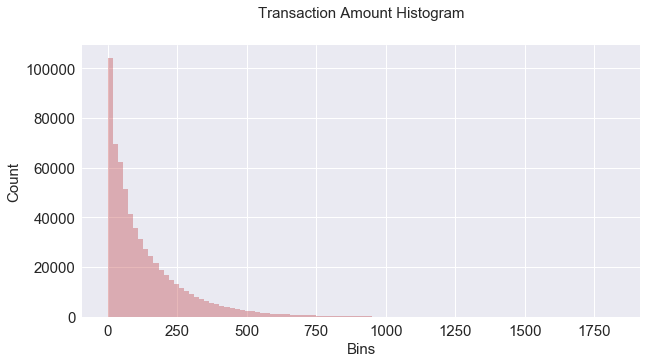

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.distplot(np.array(data.transactionAmount), kde=False, bins=100, ax=ax, color='r')
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
plt.xlabel("Bins", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Transaction Amount Histogram", fontsize=15,  y=1.08)

###### 2. Explanation 

- From the plot above, I found that the transaction amount is a highly right skewed distribution. As I mentioned above, median is 85.82, and mean is 135.19. The 75 percentile is around 189.05, and the max value 1825.25, which is far away from the whole distribution. 
<br><br>
- Below is the box plot, also shows the quantile for Transaction Amount. From the plot, I noticed that there are probably outliers in the Transaction Amount Columns. 

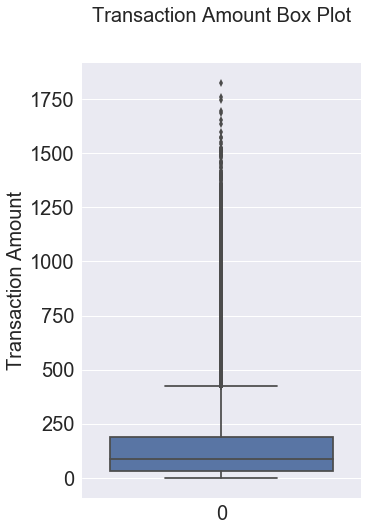

In [13]:
fig, ax = plt.subplots(figsize=(5, 8))
ax = sns.boxplot(data=data.transactionAmount)
ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20)
plt.ylabel("Transaction Amount", fontsize=20)
plt.title("Transaction Amount Box Plot", fontsize=20,  y=1.08)

### 3. Data Wrangling

- When checking the data, I found that, if one's credit card get swipeed for several time in a short time frame, all those swipeed record share several same features except the transaction time (but always happened in the same day). 
<br><br>
- For reversal, the `PURCHASE` record `REVERSAL` record also shared several features, such as `customerId`, `merchantName`, `transactionAmount`. Thus, we can use these features to track the reversal data record. Usually it happened on the same day with `PURCHASE`. However, it also could happend on different and this depends on how quick the merchance response to the request.<br><br>
- For multi-swipe data, we need to clear the duplicate, then match the cleared record with the original data to obtain it.<br><br>
- After I removing the duplicates, I check reversal by simply joining the tables since these two kinds of records share same set of features. 

In [14]:
def extract_time(orig_data, time_frame):
    data = orig_data.copy()
    data.transactionDateTime = pd.to_datetime(data.transactionDateTime)
    if time_frame == 'year':
        data['year'] = data.transactionDateTime.dt.year
    if time_frame == 'day':
        data['year'] = data.transactionDateTime.dt.day
    if time_frame == 'date':
        data['date'] = data.transactionDateTime.dt.date
    if time_frame == 'time':
        data['time'] = data.transactionDateTime.dt.time
    if time_frame == 'day':
        data['day'] = data.transactionDateTime.dt.day
    if time_frame == 'hour':
        data['hour'] = data.transactionDateTime.dt.hour
    if time_frame == 'second':
        data['second'] = data.transactionDateTime.dt.second
    return data

In [15]:
new_data = extract_time(data, 'date')
new_data = extract_time(new_data, 'hour')
# new_data = extract_time(new_data, 'second')

In [16]:
"""
FUNC mulswipe_rever_check(): return multi-swipe and reversal data 
        :param data: a pandas dataframe
        :param mul_swipe: True if user wants to get multi_swipe data.
        :param reversal: True if user wants to reversal data.
"""
def mulswipe_rever_check(data, mul_swipe = True, reversal = False):
    subset = data[['customerId', 'merchantName', 'merchantCategoryCode', 'transactionAmount', 'transactionType', 'date']]
    if mul_swipe:     
        subset = subset.drop_duplicates(keep=False)
    whole_record = data[data.index.isin(subset.index)]
    multiswip_data = data[~data.index.isin(subset.index)]
    multiswip_data = multiswip_data[multiswip_data.transactionType != 'ADDRESS_VERIFICATION']
    if reversal:   
        reversal_data = subset[whole_record.transactionType == 'REVERSAL']      
        purchase_data = subset[whole_record.transactionType == 'PURCHASE']
        reversal_data = pd.merge(reversal_data, purchase_data, on=['customerId','merchantCategoryCode', 'merchantName', 'transactionAmount'])
        return reversal_data
    return multiswip_data

In [17]:
reversal_data = mulswipe_rever_check(new_data, mul_swipe = True, reversal = True)
multiswipe_data = mulswipe_rever_check(new_data, mul_swipe = True, reversal = False)

###### 2. Inspecting 
- First of all, I inspected the 

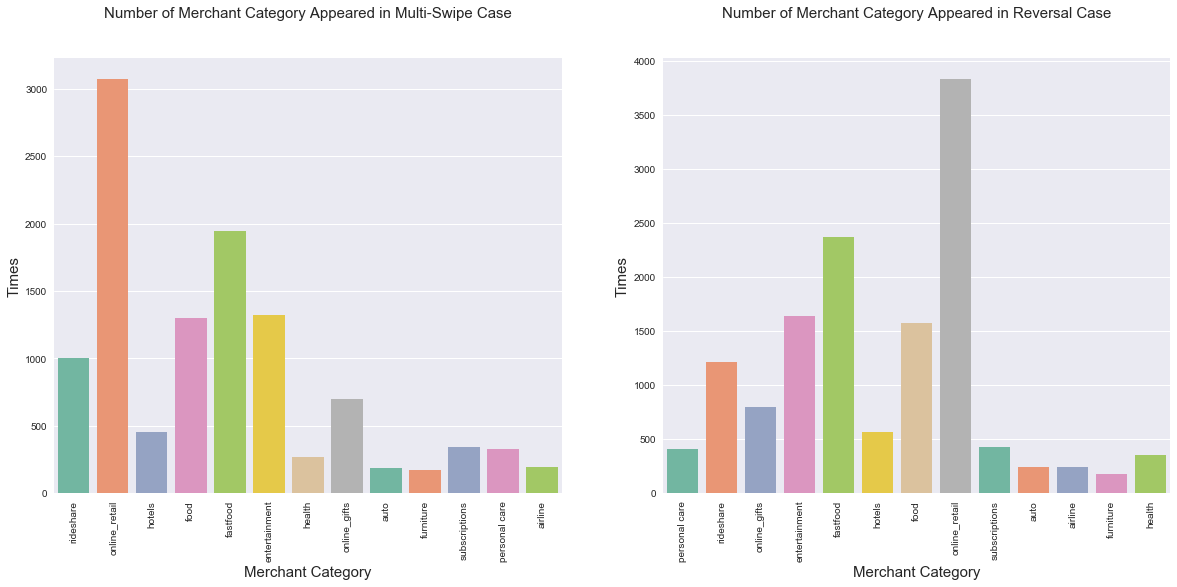

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
plt.subplot(121)
g = sns.countplot(x="merchantCategoryCode", data=multiswipe_data, palette="Set2")
# multiswipe_data.merchantCategoryCode.value_counts().plot(kind='bar')
ax[0].tick_params(axis="x", labelsize=20)
ax[0].tick_params(axis="y", labelsize=15)
plt.xlabel("Merchant Category", fontsize=15)
plt.ylabel("Times", fontsize=15)
plt.xticks(rotation=90)
plt.title("Number of Merchant Category Appeared in Multi-Swipe Case",  y=1.08, fontsize=15)

plt.subplot(122)
g = sns.countplot(x="merchantCategoryCode", data=reversal_data, palette="Set2")
# multiswipe_data.merchantCategoryCode.value_counts().plot(kind='bar')
ax[1].tick_params(axis="x", labelsize=15)
ax[1].tick_params(axis="y", labelsize=15)
plt.xlabel("Merchant Category", fontsize=15)
plt.ylabel("Times", fontsize=15)
plt.xticks(rotation=90)
plt.title("Number of Merchant Category Appeared in Reversal Case",  y=1.08, fontsize=15)

- From the plot, I found that, several categories share the same distribution for both multi-swipe data and reversal data. For example, `onelind_retail` and `fastfood`, they have majority count.

###### 3. Market Share Calculation

In [19]:
'''
FUNC multi_share_cal(): given multi_swipe data, this function will return the total multi_swipe share 
                        and the count of multi_swipes.
     :param data: multi_swipe data generated by mulswipe_rever_check().
'''
def multi_share_cal(data):
    subset_multi = data[['transactionAmount', 'merchantName', 'date']]
    subset_first = subset_multi[subset_multi.duplicated(keep='first')]
    duplicate_count = subset_first.shape[0]
    duplicate_share = np.sum(subset_first.transactionAmount)
    return duplicate_share, duplicate_count

In [20]:
duplicate_share, duplicate_count = multi_share_cal(multiswipe_data)
print("Totally multi-swipe share: ", duplicate_share)
print("Totally multi-swipe count (number of transactions): ", duplicate_count)

Totally multi-swipe share:  875642.3900000026
Totally multi-swipe count (number of transactions):  5912


- Total multi-swipe share:  875642.39
- Total multi-swipe count (number of transactions):  5912

In [21]:
'''
FUNC rever_share_cal(data): given reversal data, this function will return total reversal share and the 
                            count of reversal transactions. 
    :param data: reversal data generated by mulswipe_rever_check().
'''
def rever_share_cal(data):
    rever_count = data.shape[0]
    rever_share = np.sum(data.transactionAmount)
    return rever_share, rever_count

In [22]:
rever_share, rever_count= rever_share_cal(reversal_data)
print("Totally reversal share: ", rever_share)
print("Totally reversal count (number of transactions): ", rever_count)

Totally reversal share:  2083170.1799999913
Totally reversal count (number of transactions):  13829


- Total reversal share: 2083170.18
- Total reversal count (number of transactions):  13829

### 4.Modeling 

###### 1. Exploratory Data Analysis:  better understand our dataset. 

- Since I already removed the missing value from the first step, the total record number is $633846$.
<br><br>
- The next step is to check the distribution of the target variable again, `isFraud`.

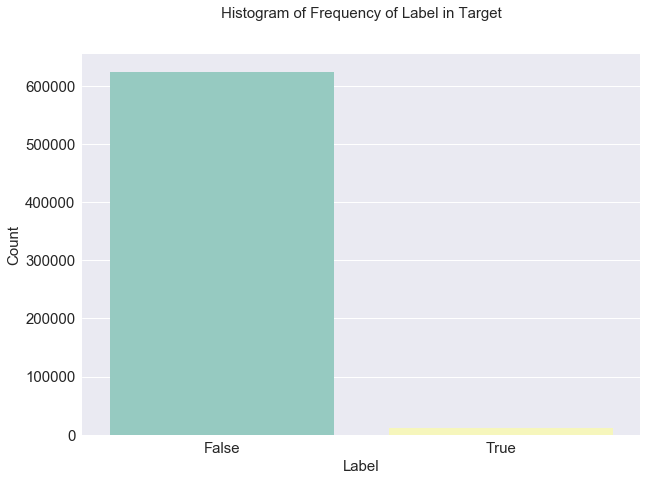

In [23]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.countplot(x="isFraud", data=data, palette="Set3")
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
plt.xlabel("Label", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Histogram of Frequency of Label in Target", fontsize=15,  y=1.08)

In [24]:
target_freq = data.isFraud.value_counts()
print("The frequency of target labels:")
print(target_freq)
False_percent = target_freq[0]/data.shape[0]
True_percent = target_freq[1]/data.shape[0]
print("Percentage of False: ", False_percent)
print("Percentage of True", True_percent)

The frequency of target labels:
False    622954
True      10892
Name: isFraud, dtype: int64
Percentage of False:  0.982816015247
Percentage of True 0.0171839847534


- From the plot, the target variable is very imbalanced, which there are 98.2% False label, 1.8% True Label.
<br><br>
- Next step I will focus on the analysis of Input variables.
    - First, I will check the correlation between each neumerical variables: `availableMoney`, `creditLimit`, `currentBalance`, and `transactionAmount`

In [25]:
numerical = data[["availableMoney", "creditLimit", 
                   "currentBalance", "transactionAmount"]]

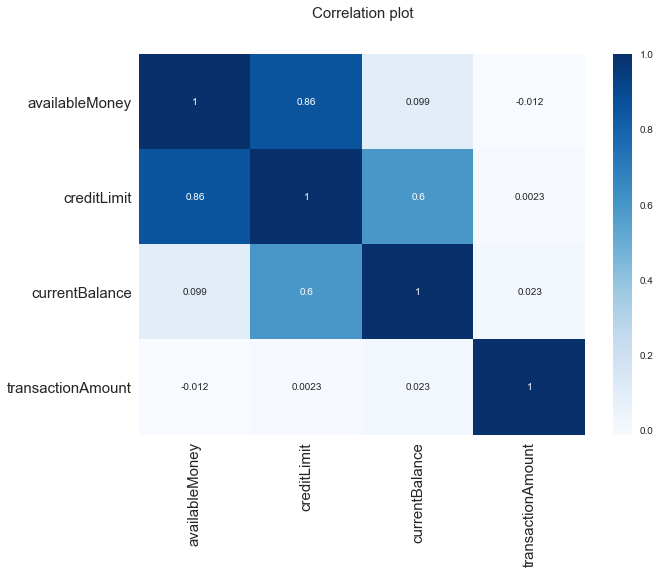

In [26]:
fig, ax = plt.subplots(figsize=(10, 7))
corr_plot = sns.heatmap(numerical.corr(),cmap='Blues',annot=True) 
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
ax.set_xticklabels(corr_plot.get_xticklabels(), rotation=90)
ax.set_yticklabels(corr_plot.get_xticklabels(), rotation=360)
plt.title("Correlation plot", fontsize=15,  y=1.08)

- From the plot, I found that 
    - `creditLimit` and `availableMoney` has a very strong correlation (0.86). 
    - `creditLimit` and `currentBalance` has a relatively strong correlation (0.6). The rest of the variables doesn't show that much of correlation between each other. 
<br><br>
- Part of the reason why they have such strong correlation is because one can easily calculate credit limit by simply add avaliable money in account and current balance together. 
<br><br>
- Since Machine Learning Algorithm like linear/logistic regression that do not handle highly correlated input variables, thus we need to left them out (`avaliableMoney`, `currentBalance`). 
<br><br>
- Alao we can check the correlation between categorical variables and target: `cardPresent`, `acqCountry`, `merchantCountryCode`, `posConditionCode`, `posEntryMode`, `transactionType`, `expirationDateKeyInMatch`.

In [27]:
def plot_histogram(x_label, hue, title, data):
    ncount = len(data)
    plt.figure(figsize=(12,8))
    ax = sns.countplot(x=x_label, hue= hue, data=data, palette="Set3")
    plt.title(title)
    plt.xlabel(x_label)
    ax2=ax.twinx()

    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')

    ax2.set_ylabel('Percentage %')

    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') 
    
    ax.yaxis.set_major_locator(ticker.LinearLocator(11))

    ax2.set_ylim(0,100)
    ax.set_ylim(0,ncount)

    ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.tick_params(axis="x", labelsize=15)
    ax.tick_params(axis="y", labelsize=15)
    ax2.tick_params(axis="y", labelsize=15)
    ax2.grid(None)

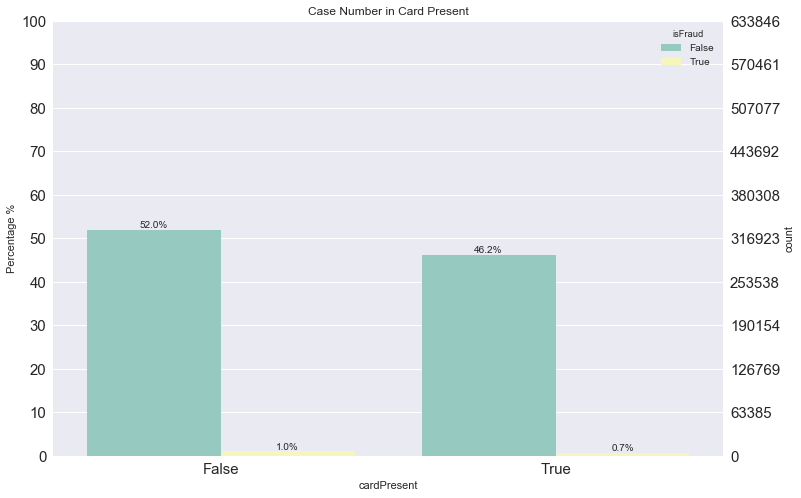

In [28]:
plot_histogram('cardPresent', 'isFraud', 'Case Number in Card Present', data)

- From above, we can see that, more fraud happened when card was not presented.

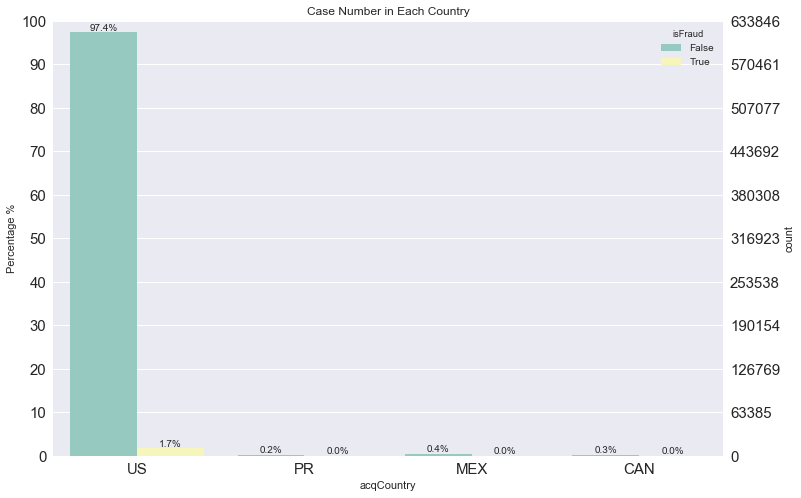

In [29]:
plot_histogram('acqCountry', 'isFraud', 'Case Number in Each Country', data)

- From the distribution, most of the records are from US. PR, MEX, and CAN have really small number of data, and also there is no fraud rate.

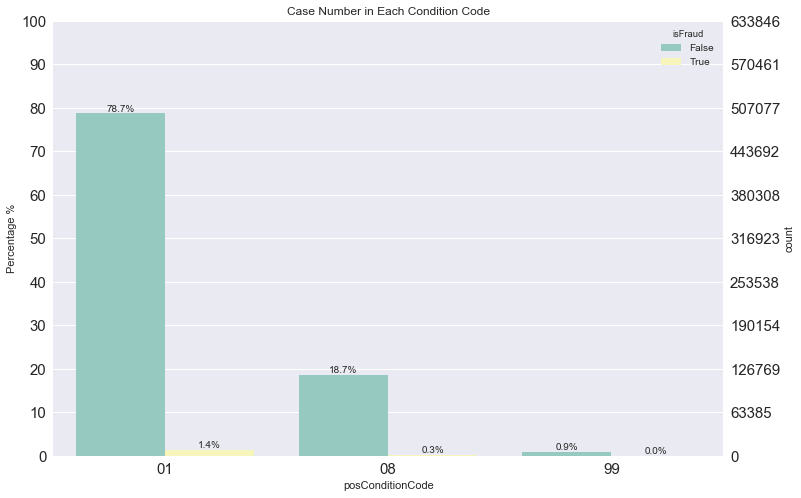

In [30]:
plot_histogram('posConditionCode', 'isFraud', 'Case Number in Each Condition Code', data)

- For `posConditionCode`, most of the cased happened in `01`, for both fraud and not fraud
- In `99`, there is only not fraud rate with 0% fraud rate. 

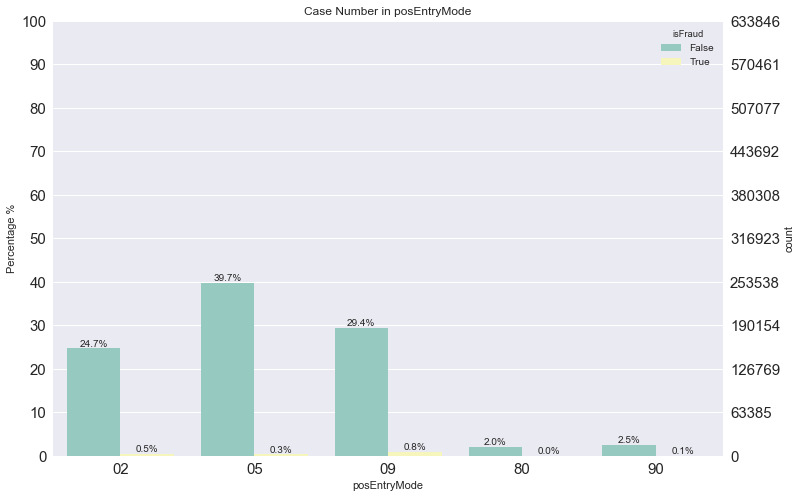

In [31]:
plot_histogram('posEntryMode', 'isFraud', 'Case Number in posEntryMode', data)

- When `posEntryMode` is `05`, it has the most non-fraud rate, however, when `posEntryMode` is `09`, it has the relatively higher fraud rate. 

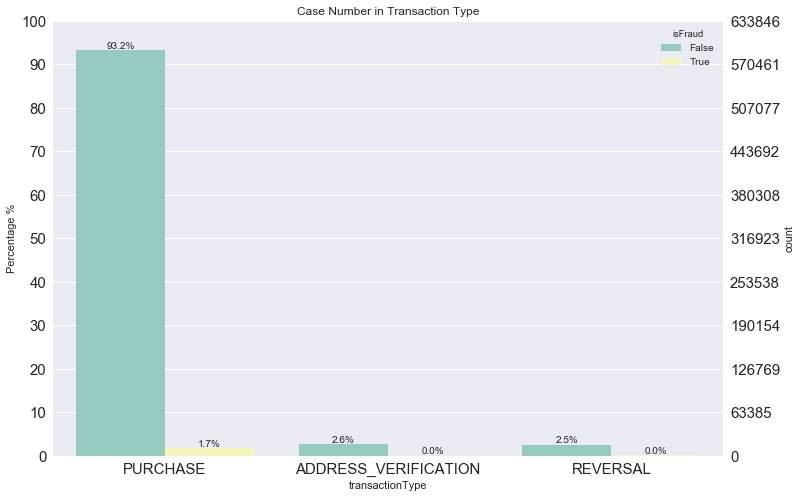

In [32]:
plot_histogram('transactionType', 'isFraud', 'Case Number in Transaction Type', data)

- This is an highly imbalanced distribution too. All the fraud happened when `PURCHASE` happenes.. 

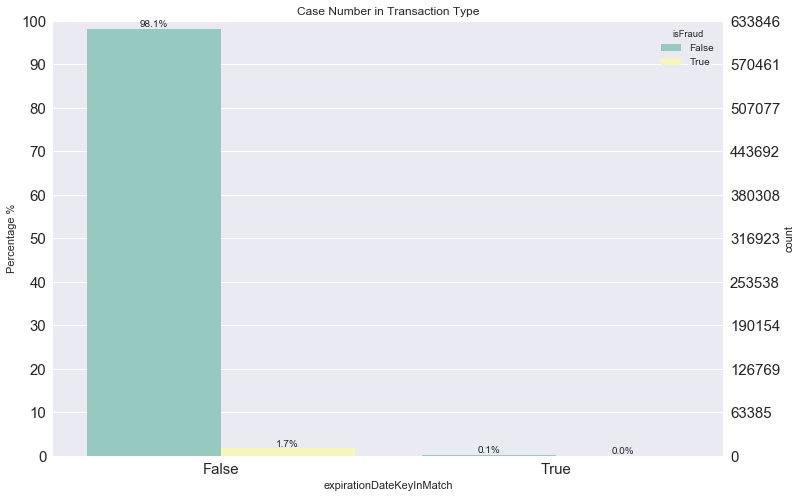

In [33]:
plot_histogram('expirationDateKeyInMatch', 'isFraud', 'Case Number in Transaction Type', data)

- For `expirationDateKeyInMatch`, the dataset is very imbalance. All most all the case include fraud or not fraud are under the False category. 

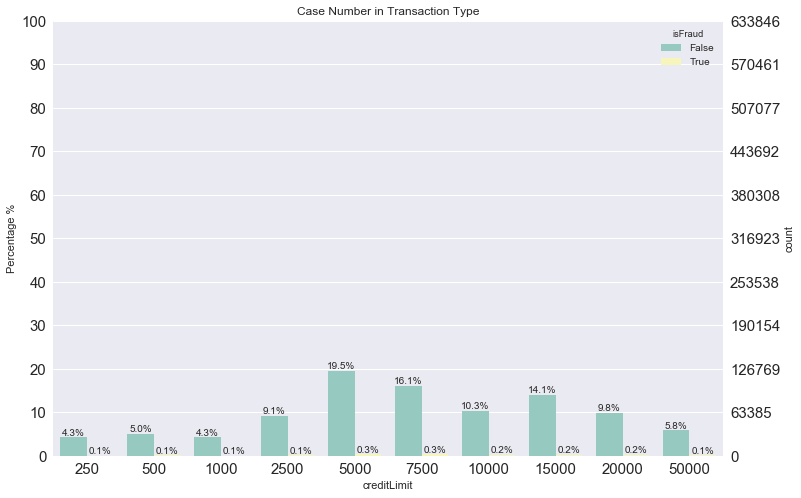

In [34]:
plot_histogram('creditLimit', 'isFraud', 'Case Number in Transaction Type', data)

- From above, I noticed that there are a level difference between the credit limit, I will dig in deeper in Feature engineer part. 

###### 2. Feature Engineer

- **Build New Feature**

In [35]:
Featured_data = data.copy()

- As I explored in section 2, there are 19 different merchant, and there's only 13 merchant has fraud appeared in the dataset. Too many categories will cause the train dataset too sparse. Thus, I decided to combine categories to accumulate fraud rate.
<br><br>
- I combine:
    - rideshare, hotels, airline: travle
    - food, fastfood, personal care, health: personal 
    - furniture, auto, entertainment, online_gifts, subscriptions, online_retail, life style
    - cable/phone, gym, food_delivery, fuel, mobileapps, online_subscriptions: 0 fraud

In [36]:
def create_new(data, new_cate, name, category):
    for i in new_cate:
        Featured_data[category][Featured_data[category] == i] = name
    return data

In [37]:
travel = ['rideshare', 'hotels', 'airline']
personal = ['food', 'fastfood', 'personal' 'care', 'health']
life_style = ['furniture', 'auto', 'entertainment', 'online_gifts', 'subscriptions', 'online_retail']
no_fraud = ['cable/phone', 'gym', 'food_delivery', 'fuel', 'mobileapps', 'online_subscriptions']

In [38]:
Featured_data = create_new(Featured_data, travel, 'travel', 'merchantCategoryCode')
Featured_data = create_new(Featured_data, personal, 'personal', 'merchantCategoryCode')
Featured_data = create_new(Featured_data, life_style, 'life_style', 'merchantCategoryCode')
Featured_data = create_new(Featured_data, no_fraud, 'no_fraud', 'merchantCategoryCode')

- Same as above, when I plot the distribution of credit level with fraud case, I notice that there exists 3 credit levels. Thus, I combine several different level into one in order to make the signal stronger that the model will have more chance to detect the fraud.

In [39]:
credit_level_1 = ['250', '500', '1000', '2500']
credit_level_2 = ['5000', '7500', '10000']
credit_level_3 = ['15000', '20000', '50000']
Featured_data.creditLimit = Featured_data.creditLimit.astype(str)

In [40]:
Featured_data = create_new(Featured_data, credit_level_1, 'credit_level_1', 'creditLimit')
Featured_data = create_new(Featured_data, credit_level_2, 'credit_level_2', 'creditLimit')
Featured_data = create_new(Featured_data, credit_level_3, 'credit_level_3', 'creditLimit')

- **Feature Selection**

   - From above, the features are going to be used in this models are:
    `cardPresent`, `creditLimit`, `merchantCategoryCode`, `posConditionCode`, `posEntryMode`, `transactionAmount`, `transactionType`.
<br><br>
   - Change Categorical to Dummy Variable

In [41]:
'''
FUNC turn_binary(): turn the column into binary representation
     :param feature_list: list that needs to be turned to binary representation
     :param data: data set with feature
'''
def turn_binary(feature_list, data):
    for feature in feature_list:
        data[feature] = data[feature] * 1
    return data

In [42]:
feature_list = ['cardPresent', 'expirationDateKeyInMatch', 'isFraud'] # 'match', # courtry_used_same 
### Treat Logistic Regression Different
Featured_data_logistic = Featured_data.copy()
Featured_data_logistic= turn_binary(feature_list, Featured_data_logistic)

In [43]:
'''
FUNC one_hot_encode(): one hot encoding the categorical variables
     :param categorical_list: list of variable that needs to be one hot encoded
     :param data: dataset has feature init. 
'''
def one_hot_encode(categorical_list, data):
    remove = list()
    for i in categorical_list:
        if (data[i].dtype == np.str or data[i].dtype == np.object):
            for j in data[i].unique():
                data[i+'_'+j] = np.where(data[i] == j,1,0)
            remove.append(i)
    data = data.drop(remove, axis=1)
    return data

In [44]:
categorical_list = ['merchantCategoryCode', 'acqCountry', 'merchantCountryCode',
       'posConditionCode', 'posEntryMode', 'transactionType', 'creditLimit']
Featured_data_logistic = one_hot_encode(categorical_list, Featured_data_logistic)

- **Drop Feature**

In [45]:
Drop_list = ['accountNumber', 'accountOpenDate', 'cardCVV', 'cardLast4Digits', 
              'currentBalance', 'currentExpDate', 'customerId', 'dateOfLastAddressChange', 
            'enteredCVV', 'merchantName', 'transactionDateTime', 'availableMoney']

'''
FUNC drop_column(): drop columns from the dataset.
     :param drop_list: columns that needs to be droped
'''
def drop_column(drop_list, data):
    try:
        data = data.drop(Drop_list, axis=1)
    except:
        print("Already Drop")
    return data

In [46]:
Featured_data = drop_column(Drop_list, Featured_data)
Featured_data_logistic = drop_column(Drop_list, Featured_data_logistic)

In [47]:
'''
FUNC encode_label(): Encode label in order to run it in model.
     :param column_name: the column that needs to be encoded
'''
def encode_label(column_name, data):
    try:
        le = LabelEncoder()
        le.fit(data[column_name])
        data[column_name] = le.transform(data[column_name])
    except:
        print("already encode")
    return data

In [48]:
Featured_data = encode_label('acqCountry', Featured_data)
Featured_data = encode_label('creditLimit', Featured_data)
Featured_data = encode_label('merchantCategoryCode', Featured_data)
Featured_data = encode_label('merchantCountryCode', Featured_data)
Featured_data = encode_label('transactionType', Featured_data)
Featured_data = encode_label('posEntryMode', Featured_data)
Featured_data = encode_label('posConditionCode', Featured_data)

- **Standardize the Continous Variable**

In [49]:
Featured_data_logistic['transactionAmount'] = StandardScaler().fit_transform(Featured_data_logistic[['transactionAmount']])
Featured_data['transactionAmount'] = StandardScaler().fit_transform(Featured_data[['transactionAmount']])

In [50]:
Featured_data_logistic.columns

Index(['cardPresent', 'expirationDateKeyInMatch', 'isFraud',
       'transactionAmount', 'merchantCategoryCode_travel',
       'merchantCategoryCode_life_style', 'merchantCategoryCode_personal care',
       'merchantCategoryCode_personal', 'merchantCategoryCode_no_fraud',
       'acqCountry_US', 'acqCountry_PR', 'acqCountry_MEX', 'acqCountry_CAN',
       'merchantCountryCode_US', 'merchantCountryCode_PR',
       'merchantCountryCode_MEX', 'merchantCountryCode_CAN',
       'posConditionCode_01', 'posConditionCode_08', 'posConditionCode_99',
       'posEntryMode_05', 'posEntryMode_09', 'posEntryMode_02',
       'posEntryMode_90', 'posEntryMode_80', 'transactionType_PURCHASE',
       'transactionType_ADDRESS_VERIFICATION', 'transactionType_REVERSAL',
       'creditLimit_credit_level_2', 'creditLimit_credit_level_1',
       'creditLimit_credit_level_3'],
      dtype='object')

###### 3. Modeling 

- **Train/Validation/Test Split** 

In [51]:
'''
FUNC ts_split(): split dataset into train/validation/test
'''
def ts_split(data):
    Target = data['isFraud']
    Input = data.drop('isFraud', axis = 1)
    X_train, X_val, y_train, y_val = train_test_split(Input, Target, test_size= 0.3, stratify=Target, random_state = 204)
    X_val, X_test, y_val, y_test= train_test_split(X_val, y_val, test_size= 0.5, stratify=y_val, random_state = 204)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [52]:
X_train, X_val, X_test, y_train, y_val, y_test = ts_split(Featured_data)
X_train_logistic, X_val_logistic, X_test_logistic, y_train_logistic, y_val_logistic, y_test_logistic = ts_split(Featured_data_logistic)

- **Resample Data**
    - Since our target varibale is very sparse, when train the model, the majority class will have larger weight. Thus, when make prediction, the performance won't be that good.
    <br><br>
    - One method is to resample the data, make the target variable more balance.

In [53]:
sm = SMOTE(sampling_strategy = 'minority', random_state=204, k_neighbors=1, kind='regular')
X_train, y_train= sm.fit_resample(X_train, y_train)
X_train_logistic, y_train_logistic= sm.fit_resample(X_train_logistic, y_train_logistic)

In [54]:
X_train = pd.DataFrame(X_train, columns = Featured_data.drop('isFraud', axis=1).columns)
X_train_logistic = pd.DataFrame(X_train_logistic, columns = Featured_data_logistic.drop('isFraud', axis=1).columns)

- **Model Evaluation Functions**
    - Since the dataset is very imbalanced, accuracy will not be a proper evaluation method in this case. 
    <br><br>
    - For imbalanced dataset, roc-auc, recall, precision are always deployed as extra measurements. These evaluation metrices will provide us more information about if the model can actually distinguish the positive case and negative case. 
       - Eespecially, I think recall is important in Fraud detection becuase it will prevent company from losing money. I will explain more in later section.

In [55]:
'''
FUNC roc_auc: given target train, target validation and their corresponding prediction,
              the function will plot AUC-ROC curve.
     :param y_train, y_val: original target variable 
     :param ytrain_pred, yval_pred: predicted target variable 
'''
def roc_auc(y_train, ytrain_pred, y_val, yval_pred):
    auc_roc_train = roc_auc_score(y_train, ytrain_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, ytrain_pred)
    auc_roc_val = roc_auc_score(y_val, yval_pred)
    fpr_val, tpr_val, _ = roc_curve(y_val, yval_pred)
    plt.figure(figsize=(10,5))
    plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='ROC Train (AUC = {0:.2f})'.format(auc_roc_train))
    plt.plot(fpr_val, tpr_val, color='red', lw=2, label='ROC Validation (AUC = {0:.2f})'.format(auc_roc_val))
    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('AUC-ROC Curve')
    plt.legend(loc="lower right")

In [56]:
'''
FUNC calculate_score(): calculate scores include auc-roc, precision, recall, f1, and accuracy
    :param train, predict, pred_prob: target train data, predicted target, 
                predicted probabilty for each case in target
'''
def calculate_score(train, predict, pred_prob):
    auc = roc_auc_score(train, pred_prob)
    precision = precision_score(train, predict)
    recall = recall_score(train, predict)
    f1 = f1_score(train, predict)
    return [auc, precision, recall, f1]

In [57]:
'''
FUNC evaluation_methods(): return evaluation result include AUC score, Precision, Recall, F1 score 
    :param y_train, y_val: original target variable 
    :param ytrain_pred, yval_pred, ytrain_prob, yval_prob: predicted target variable and the probabilities
'''
def evaluation_methods(y_train, ytrain_pred, ytrain_prob, y_val, yval_pred, yval_prob):
    methods = ['AUC score','Precision','Recall','F1']
    train_result = calculate_score(y_train, ytrain_pred, ytrain_prob)
    val_result = calculate_score(y_val, yval_pred, yval_prob)
    result = pd.DataFrame({'evaluation methods':methods, 'train':train_result,'validation':val_result},
                          columns=['evaluation methods','train','validation']).set_index('evaluation methods')
    return result

In [58]:
'''
FUNC model_evaluation(): Given model and data (train, validation), return evaluation result
    :param model: model that is already fitted with train data
    :param  X_train, y_train, X_val, y_val: prepared datasets
'''
def model_evaluation(model, X_train, y_train, X_val, y_val):

    ytrain_pred = model.predict(X_train)
    y_train_prob = model.predict_proba(X_train)
    y_train_prob = [p[1] for p in y_train_prob]
    
    yval_pred = model.predict(X_val)
    y_val_prob= model.predict_proba(X_val)
    y_val_prob = [p[1] for p in y_val_prob]

    eva_result = evaluation_methods(y_train, ytrain_pred, y_train_prob, y_val, yval_pred, y_val_prob)
    print(eva_result)
    roc_auc(y_train, y_train_prob, y_val, y_val_prob)

- **Logistic Regression**
    - The most common model when dealing with binary classification is Logistic Regression, which is a linear type model. 
    - There are several problems with logistic regression for example, easy to overfit or cannot capture complicated non-linear relationship. 
    - In this case, logistic regression did't show a good performance based on the AUC score it obtained. 

                       train  validation
evaluation methods                      
AUC score           0.738326    0.737812
Precision           0.660254    0.033028
Recall              0.719842    0.722766
F1                  0.688762    0.063170


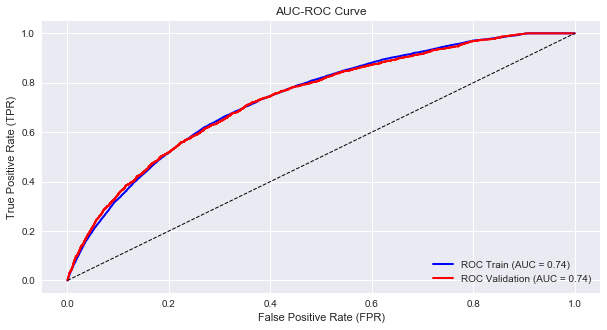

In [73]:
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train_logistic, y_train_logistic)
model_evaluation(logistic_reg, X_train_logistic, y_train_logistic, X_val_logistic, y_val_logistic)

- **Random Forest**
    - Random Forest is another commom use model when working on classification problem, also it can be used modeling regression problem as well.
    - Because of the use of bagging, it reduced variance with out bring any bias (potentially). Also random selecting feature makes sure to decorrelated the feature as much as possible. 
    - It's not easy to overfit, and works well on non-linear problem
    - From the ressult below, Random Forest gets more higer accuracy compared to logistic regression.

                       train  validation
evaluation methods                      
AUC score           0.746955    0.739824
Precision           0.672778    0.034128
Recall              0.716381    0.703182
F1                  0.693895    0.065097


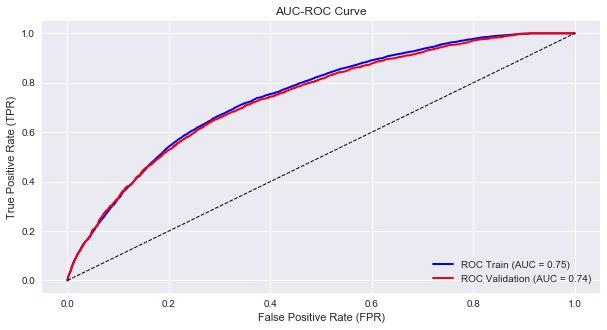

In [83]:
rf_param = {'n_estimators': 45,
              'max_depth': 5,
              'min_samples_split': 2,
              'min_samples_leaf': 10,
              'n_jobs': -1,
              'min_weight_fraction_leaf': 0.001,
               'class_weight': "balanced_subsample",
               'criterion' : 'gini',
              } ##The set of hyperparameter Choose by Grid Search
random_forest = RandomForestClassifier(**rf_param)
random_forest.fit(X_train_logistic, y_train_logistic)
model_evaluation(random_forest, X_train_logistic, y_train_logistic, X_val_logistic, y_val_logistic)

In [ ]:
'''
Code for grid Search
'''
random_forest = RandomForestClassifier()
param_grid = {'n_estimators': [45, 90], 
              'max_depth': [5, 10, 15], 
              'min_samples_split': [2],
              'min_samples_leaf': [20],
              'n_jobs': [-1],
              'class_weight': ["balanced_subsample"]
             }
evaluation = make_scorer(f1_score)
grad_sh = GridSearchCV(random_forest, param_grid, cv=5, scoring=evaluation)
grad_sh = grad_sh.fit(X_train_logistic, y_train_logistic)
rf_prime = grad_sh.best_estimator_
rf_prime.fit(X_train_logistic, y_train_logistic)

- **XGBOOST**
   - Xgboost is a model based on gradient boosting, which is another popular methods when working on classification problem.
   - The main technique inside the Xgboost is boosting, which train learners sequentially, and it evantually will convert weak learners into strong classifier. 
   - One of the goal of this algorithm is to push the limit of computations resources for boosted tree algorithms, which means running faster than gradient boosting.  

In [84]:
xgb_param = {
            'objective':'binary:logistic',
            'colsample_bytree':0.3,
            'learning_rate':0.1,
            'max_depth':4,
            'reg_alpha':1,
            'n_estimators':50,
            }

                       train  validation
evaluation methods                      
AUC score           0.761089    0.747227
Precision           0.679302    0.034804
Recall              0.723073    0.701958
F1                  0.700505    0.066320


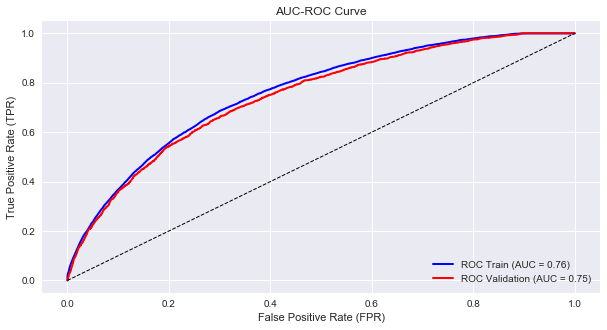

In [85]:
xg_class = xgb.XGBClassifier(**xgb_param)
xg_class.fit(X_train, y_train)
model_evaluation(xg_class, X_train, y_train, X_val, y_val)

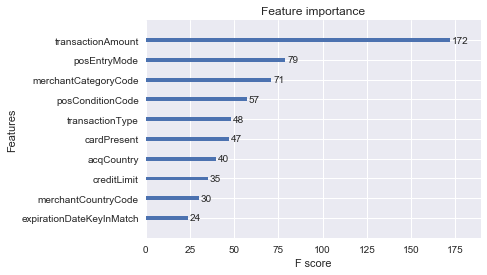

In [86]:
xgb.plot_importance(xg_class)

From feature importance plot, I noticed that transactionAmount is the most important variable. 

- **Summary**
    - After I fine-tuned parameter on 3 different models and compared the result, XGBOOST would be a good model for this dataset as it has relatively high AUC-ROC, and recall, precision from the result.
       - people tends to choose high AUC-ROC score model, since the metrices shows the ability how model could distinguish between two classes.
       <br><br>
    - Because of the fact of the imbalanced dataset, it's not easy to boost the performance of precision. However, I think recall is more important in this case. 
        - $Recall = \frac{True\ Positive}{True\ Positive + False\ Negative}$. From the formula, if Recall is increased, False Negative will be decreased (False positive increase), which the model will predict more fraud instead of non-fraud. And the prediction will potentially cover the fraud case. 
        <br><br>
        - For fraud detection, I think it's better to detect the case as a fraud instead of not. If the record is positive and predict negative, the company will lose money by these kind of prediction error. 
            - For example, if a fraud happened to a very important customer, and the model did not detect it successfully, the customer will lose a lot of money, and the company probablly will lose the customer's loyalty. Eventullay, this will be a great loss for credit card company.
            <br><br>
            - However, if our model detects the transaction as a fraud but it is not, this won't hurt customer since they can simply verify it with credit card company by click a button.
        <br><br>
    - For the future work, I will explore the dataset in more detail and try to create more useful feature to boost model performace. Also I will fine-tune the model again to obtain more prime result.